In [12]:
from FAdo.fa import *
from FAdo.reex import *
from FAdo.fio import *
from FAdo.rndadfa import *

import lark

In [134]:
class CPower(Power):
	def __init__(self, arg, n, sigma=None):
		self.arg = arg
		self.n = n
		self.sigma = sigma
		super().__init__(arg, n, sigma)

	def linearForm(self):
		arg_lf = self.arg.linearForm()
		lf = dict()
		for head in arg_lf:
			lf[head] = set()
			for tail in arg_lf[head]:
				if tail.emptysetP():
					lf[head].add(CEmptySet(self.Sigma))
				elif tail.epsilonP():
					if self.n - 1 == 1:
						lf[head].add(self.arg)
					else:
						lf[head].add(CPower(self.arg, self.n-1, self.Sigma))
				else:
					if self.n - 1 == 1:
						lf[head].add(CConcat(tail, self.arg, self.Sigma))
					else:
						lf[head].add(CConcat(tail, CPower(self.arg, self.n-1, self.Sigma), self.Sigma))
		return lf

	def partialDerivatives(self, sigma):
		return self.arg.partialDerivatives(sigma)

	def derivative(self, sigma):
		d = self.arg.derivative(sigma)
		if self.n-1 == 1:
			return CConcat(d, self.arg, self.Sigma)
		else:
			return CConcat(d, CPower(self.arg, self.n-1, self.Sigma), self.Sigma)

		print(f"{self.Sigma} derivative with respect to {sigma}")

		if str(sigma) == str(self.Sigma):
			if self.n - 1 == 1:
				return self.arg
			else:
				return CPower(self.arg, self.n-1, self.Sigma)

In [188]:
class CCount(Unary):
	def __init__(self, arg, min, max = None, sigma=None):
		self.arg = arg
		self.min = int(min)
		self.max = "inf" if max == -1 else max
		self.Sigma = sigma
	
	def __str__(self):
		"""String representation of the regular expression."""
		return '({}){{{},{}}}'.format(self.arg, self.min, self.max if self.max != "inf" else '')
	
	def _strP(self):
		"""String representation of the regular expression."""
		return '({}){{{},{}}}'.format(self.arg, self.min, self.max if self.max != "inf" else '')

	def __repr__(self):
		"""Representation of the regular expression's syntactical tree."""
		return 'CCount({},[{}])'.format(self.arg, self.min if not self.max else '{},{}'.format(self.min, self.max))
	
	def epsilonP(self):
		if self.max == "inf" or self.max == None:
			return self.min == 0
		else:
			m_v = int(self.max)
			return self.min == 0 and m_v == 0
		
	def ewp(self):
		return False

	def emptysetP(self):
		return False
	
	def derivative(self, sigma):
		def nested(values):
			if not values:
				return None
			elif len(values) == 1:
				return values[0]
			else:
				return CDisj(values[0], nested(values[1:]))

		if self.max == "inf":
			lst = []
			for i in range(self.min, 0, -1):
				k = CPower(self.arg, i, self.Sigma)
				lst.append(k.derivative(sigma))
			lst.append(CStar(self.arg, self.Sigma))

			return nested(lst)
		else:
			lst = [CPower(self.arg, i, self.Sigma).derivative(sigma) for i in range(self.min, int(self.max)+1)]
			return nested(lst)
	
	def linearForm(self):
		arg_lf = self.arg.linearForm()
		lf = dict()
		for head in arg_lf:
			lf[head] = set()
			for tail in arg_lf[head]:
				if tail.emptysetP():
					lf[head].add(CEmptySet(self.Sigma))
				elif tail.epsilonP():
					if self.min == 0:
						lf[head].add(CStar(self.arg, self.Sigma))
				else:
					if self.min == 0:
						lf[head].add(CConcat(tail, CStar(self.arg, self.Sigma), self.Sigma))
		return lf

	def partialDerivatives(self, sigma):
		arg_pdset = self.arg.partialDerivatives(sigma)
	
		#print(arg_pdset)
		pds = set()
		for pd in arg_pdset:
			if pd.emptysetP():
				pds.add(CEmptySet(self.Sigma))
			elif pd.epsilonP():
				pds.add(self)
			else:
				pds.add(CConcat(pd, self, self.Sigma))
		return pds

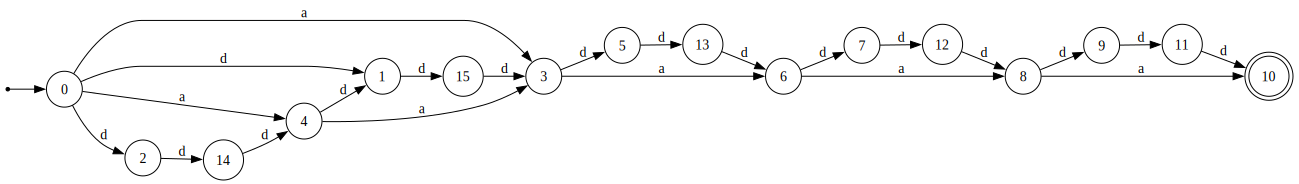

In [210]:
#class BuildRegexpCC(BuildRegexp):
def nested(values):
    if not values:
        return None
    elif len(values) == 1:
        return values[0]
    else:
        return CDisj(values[0], nested(values[1:]))

def pow_min(self, s, inf=False):
    (arg, n_r) = s
    n = int(n_r.children[0].value)
    if inf:
        if n == 0:
            r = CStar(arg, self.sigma)
        else:
            r = CConcat(CPower(arg, n, self.sigma), CStar(arg, self.sigma), self.sigma)
            #r = CCount(arg, n, -1, self.sigma)
    else:
        if n == 0:
            r = CEpsilon()
        elif n == 1:
            r = arg
        else:
            r = CPower(arg, n, self.sigma)

    r._ewp = False

    return r

def pow_minmax(self, s):
    (arg, n_mi, n_ma) = s
    n_min = n_mi.children[0].value
    n_max = n_ma.children[0].value

    lst = []
    for i in range(int(n_max), int(n_min)-1, -1):
        k = CPower(arg, i, self.sigma)
        lst.append(k)

    r = nested(lst)
    r._ewp = False
    return r

def pow_inf(self, s):
    return self.pow_min(s, True)

BuildRegexp.pow_min = pow_min
BuildRegexp.pow_minmax = pow_minmax
BuildRegexp.pow_inf = pow_inf
    
regGrammar = lark.Lark.open("regexp_test.lark", start="rege", parser="lalr")

# available:
# b^[1] -> 'b'
# b^[1,2] -> 1 <= 'b' <= 2
# b^[1,...] -> 1 <= 'b' <= inf

tree = regGrammar.parse("((a+(d^[3]))^[4,5])")
reg = BuildRegexp(context={"sigma": None}).transform(tree)
reg.setSigma(reg.setOfSymbols())
#kk = reg.partialDerivatives('a')
reg.toNFA(nfa_method="nfaPDNaive").display()

#reg.toNFA(nfa_method="nfaPDNßaive").display() # <= Ativar isto muda algum objeto da classe CCount????
#print(reg.derivative('b'))
#reg.partialDerivatives('b')


In [70]:
x = str2regexp("a*")
x.derivative("a")

CConcat(CEpsilon(),CStar(CAtom(a)))